In [1]:

import pandas as pd
from pathlib import Path
import gzip
from plotnine import *
from scipy import stats
from socialgene.base.socialgene import SocialGene
from socialgene.neo4j.neo4j import GraphDriver 
from socialgene.config import env_vars
from socialgene.compare_proteins.hmm_scoring import mod_score

env_vars["NEO4J_URI"] = "bolt://localhost:7687"


In [2]:
with GraphDriver() as db:
    results1 = db.run(
        """
        CALL db.labels() YIELD label
        CALL apoc.cypher.run('MATCH (:`'+label+'`) RETURN count(*) as count',{}) YIELD value
        RETURN label, value.count
        """
    ).to_df()
results1.sort_values("label")

2024-08-07 15:19:41 INFO     Connected to Neo4j database at bolt://localhost:7687                                                          ]8;id=23167;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/neo4j/neo4j.py\neo4j.py]8;;\:]8;id=973817;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/neo4j/neo4j.py#61\61]8;;\

,label,value.count
10,amrfinder,630
13,antismash,941
6,assembly,3
0,goterm,51502
7,hmm,25566
9,hmm_source,25814
4,nucleotide,3
12,parameters,1
8,pfam,19632
5,protein,16233


In [3]:
with GraphDriver() as db:
    results1 = db.run(
        """
        CALL db.relationshipTypes() YIELD relationshipType as type
        CALL apoc.cypher.run('MATCH ()-[:`'+type+'`]->() RETURN count(*) as count',{}) YIELD value
        RETURN type as label, value.count
        """
    ).to_df()
results1.sort_values("label")

,label,value.count
5,ALTERNATE,3646
9,ANNOTATES,48306
2,ASSEMBLES_TO,3
15,BLASTP,31567
0,ENCODES,16318
3,GO_ANN,6387
4,IS_A,27567
1,IS_TAXON,3
14,MAINROLE_ANN,116
11,MMSEQS_30,14750


In [4]:
%%time
with GraphDriver() as db:
    results1 = db.run(
        """
        MATCH (p1:protein)<-[:MMSEQS_90]-(pz:protein) 
        MATCH (p2:protein)<-[:MMSEQS_90]-(pz)
        MATCH z=(p1)-[r:BLASTP]-(p2)
        return p1.uid as a, p2.uid as b, pz.uid as uid, r.pident as pident,  'MMSEQS_90' as z
        """
    ).to_df()

with GraphDriver() as db:
    results2 = db.run(
        """
        MATCH (p1:protein)<-[:MMSEQS_90]-(m90:protein)-[:MMSEQS_70]-(pz:protein) 
        MATCH (p2:protein)<-[:MMSEQS_90]-(:protein)-[:MMSEQS_70]-(pz) 
        WHERE  NOT (p2)<-[:MMSEQS_90]-(m90) 
        MATCH z=(p1)-[r:BLASTP]-(p2)
        return p1.uid as a, p2.uid as b, pz.uid as uid, r.pident as pident, 'MMSEQS_70' as z
        """
    ).to_df()


with GraphDriver() as db:
    results3 = db.run(
        """
        MATCH (p1:protein)<-[:MMSEQS_90]-(:protein)-[:MMSEQS_70]-(m70:protein)-[:MMSEQS_50]-(pz:protein) 
        MATCH (p2:protein)<-[:MMSEQS_90]-(:protein)-[:MMSEQS_70]-(:protein)-[:MMSEQS_50]-(pz) 
        WHERE  NOT (p2)<-[:MMSEQS_90]-(:protein)-[:MMSEQS_70]-(m70)
        MATCH z=(p1)-[r:BLASTP]-(p2)
        return p1.uid as a, p2.uid as b, pz.uid as uid, r.pident as pident, 'MMSEQS_50' as z
        """
    ).to_df()
    
with GraphDriver() as db:
    results4 = db.run(
        """
        MATCH (p1:protein)<-[:MMSEQS_90]-(:protein)<-[:MMSEQS_70]-(:protein)<-[:MMSEQS_50]-(m50:protein)<-[:MMSEQS_30]-(pz:protein)
        MATCH (p2:protein)<-[:MMSEQS_90]-(:protein)<-[:MMSEQS_70]-(:protein)<-[:MMSEQS_50]-(:protein)<-[:MMSEQS_30]-(pz)
        WHERE  NOT (p2)<-[:MMSEQS_90]-(:protein)-[:MMSEQS_70]-(:protein)-[:MMSEQS_50]-(m50)
        MATCH z=(p1)-[r:BLASTP]-(p2)
        return p1.uid as a, p2.uid as b, pz.uid as uid, r.pident as pident, 'MMSEQS_30' as z        
        """
    ).to_df()
with GraphDriver() as db:
    results5 = db.run(
        """
        MATCH z=(p1)-[r:BLASTP]-(p2)
        WITH p1, p2, max(r.pident) as pident
        return p1.uid as a, p2.uid as b, pident, 'DIAMOND' as z
        """
    ).to_df()


CPU times: user 2.19 s, sys: 340 ms, total: 2.53 s
Wall time: 6.56 s


In [5]:
# combine the results
results = pd.concat([results1, results2, results3, results4, results5])

In [6]:
# remove reverse duplicates
results["temp"] = results.apply(lambda x: "".join(sorted([x["a"], x["b"]])), axis=1)
results.sort_values("temp", inplace=True)
results.drop_duplicates(subset=["temp", "z"], inplace=True)
results.drop(columns=["temp"], inplace=True)

In [7]:
results.groupby("z")['pident'].count()

z
DIAMOND      16290
MMSEQS_30     9165
MMSEQS_50     1992
MMSEQS_70      250
MMSEQS_90       72
Name: pident, dtype: int64

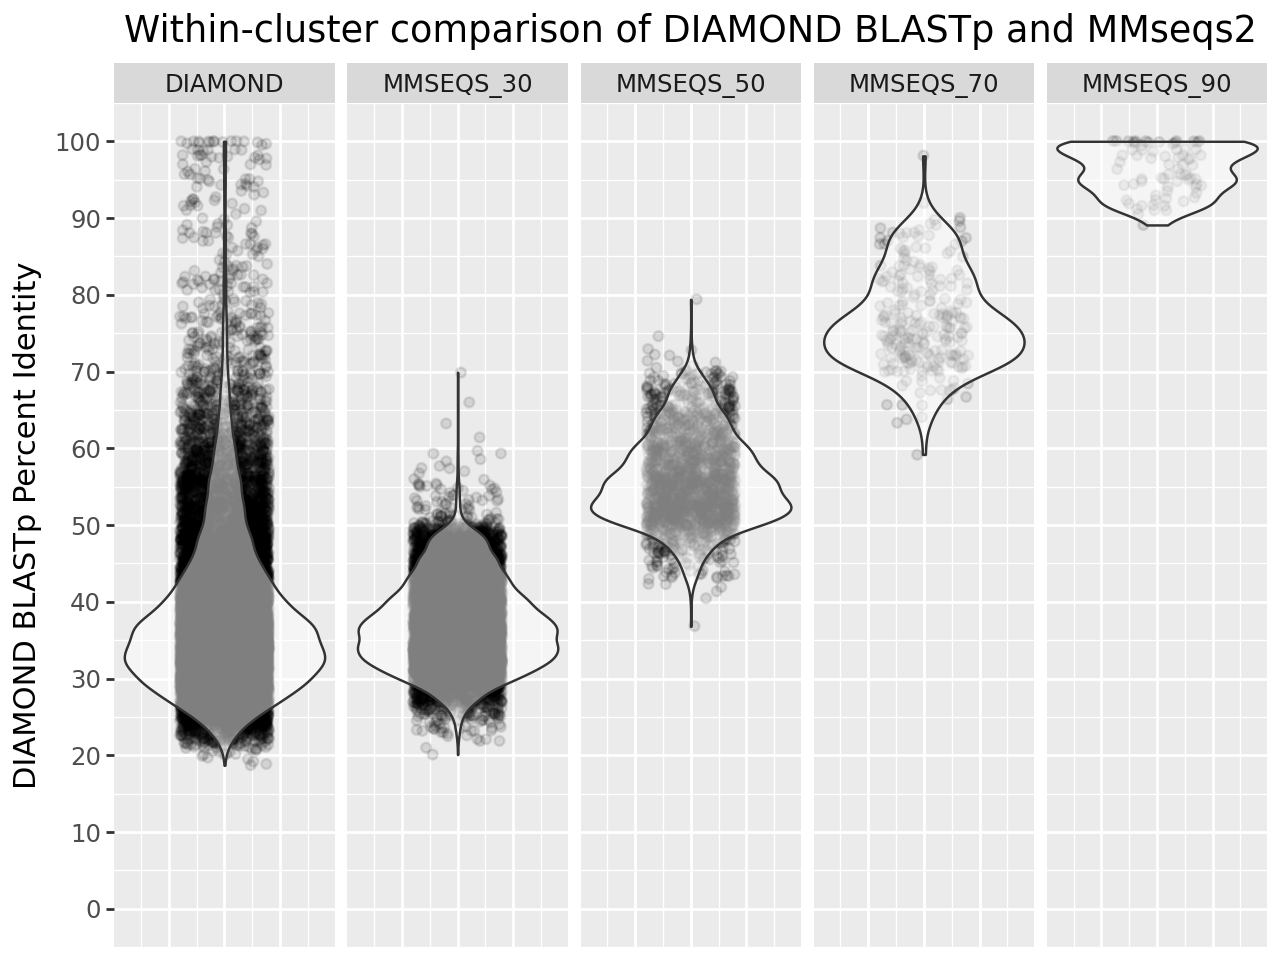

In [8]:
(
    ggplot(results, aes(x=0, y="pident")) +
        geom_point(position = position_jitter( width = 0.2), alpha=0.1) +
        geom_violin( alpha=0.5) +
        coord_cartesian(ylim=(0, 100)) +
        facet_wrap("~z", ncol=5) +
        scale_y_continuous(breaks = range(0, 110, 10)) +
        ylab("DIAMOND BLASTp Percent Identity") +
        theme(axis_title_x=element_blank(),
              axis_text_x=element_blank(),
              axis_ticks_x=element_blank(),
              ) +
        ggtitle("Within-cluster comparison of DIAMOND BLASTp and MMseqs2") +
          theme(plot_title = element_text(hjust = 0.5))
)

---

In [9]:
%%time
with GraphDriver() as db:
    results1 = db.run(
        """
    MATCH z=(p1)-[r:BLASTP]-(p2)
    WHERE NOT (p1)<-[:MMSEQS_90]-(:protein)-[:MMSEQS_90]->(p2) 
    WITH apoc.coll.sort([p1.uid, p2.uid]) as pair, max(r.pident) as pident
    RETURN pair[0] as a, pair[1] as b, pident, 'mmseqs_90' as z
        """
    ).to_df()

# not mmseqs 70
with GraphDriver() as db:
    results2 = db.run(
        """
        MATCH z=(p1)-[r:BLASTP]-(p2)
        WHERE 
            NOT (p1)<-[:MMSEQS_90]-(:protein)-[:MMSEQS_90]->(p2) 
            AND NOT (p1)<-[:MMSEQS_90]-(:protein)<-[:MMSEQS_70]-(:protein)-[:MMSEQS_70]->(:protein)-[:MMSEQS_90]->(p2)
        WITH apoc.coll.sort([p1.uid, p2.uid]) as pair, max(r.pident) as pident        
        RETURN pair[0] as a, pair[1] as b, pident, 'mmseqs_70' as z      
        """
    ).to_df()

# not mmseqs 50
with GraphDriver() as db:
    results3 = db.run(
        """
        MATCH z=(p1)-[r:BLASTP]-(p2)
        WHERE 
            NOT (p1)<-[:MMSEQS_90]-(:protein)-[:MMSEQS_90]->(p2) 
            AND NOT (p1)<-[:MMSEQS_90]-(:protein)<-[:MMSEQS_70]-(:protein)-[:MMSEQS_70]->(:protein)-[:MMSEQS_90]->(p2)
            AND NOT (p1)<-[:MMSEQS_90]-(:protein)<-[:MMSEQS_70]-(:protein)<-[:MMSEQS_50]-(:protein)-[:MMSEQS_50]->(:protein)-[:MMSEQS_70]->(:protein)-[:MMSEQS_90]->(p2)
        WITH apoc.coll.sort([p1.uid, p2.uid]) as pair, max(r.pident) as pident
        RETURN pair[0] as a, pair[1] as b, pident, 'mmseqs_50' as z
        """
    ).to_df()

# not mmseqs 30

with GraphDriver() as db:
    results4 = db.run(
        """
        MATCH z=(p1)-[r:BLASTP]-(p2)
        WHERE 
            NOT (p1)<-[:MMSEQS_90]-(:protein)-[:MMSEQS_90]->(p2) 
            AND NOT (p1)<-[:MMSEQS_90]-(:protein)<-[:MMSEQS_70]-(:protein)-[:MMSEQS_70]->(:protein)-[:MMSEQS_90]->(p2)
            AND NOT (p1)<-[:MMSEQS_90]-(:protein)<-[:MMSEQS_70]-(:protein)<-[:MMSEQS_50]-(:protein)-[:MMSEQS_50]->(:protein)-[:MMSEQS_70]->(:protein)-[:MMSEQS_90]->(p2)
            AND NOT (p1)<-[:MMSEQS_90]-(:protein)<-[:MMSEQS_70]-(:protein)<-[:MMSEQS_50]-(:protein)<-[:MMSEQS_30]-(:protein)-[:MMSEQS_30]->(:protein)-[:MMSEQS_50]->(:protein)-[:MMSEQS_70]->(:protein)-[:MMSEQS_90]->(p2)
        WITH apoc.coll.sort([p1.uid, p2.uid]) as pair, max(r.pident) as pident
        RETURN pair[0] as a, pair[1] as b, pident, 'mmseqs_30' as z
        """
    ).to_df()

CPU times: user 1.35 s, sys: 205 ms, total: 1.56 s
Wall time: 10.1 s


In [10]:
results = pd.concat([results1, results2, results3, results4])

In [11]:
# remove reverse duplicates
results["temp"] = results.apply(lambda x: "".join(sorted([x["a"], x["b"]])), axis=1)
results.sort_values("temp", inplace=True)
results.drop_duplicates(subset=["temp", "z"], inplace=True)
results.drop(columns=["temp"], inplace=True)

In [12]:
results

,a,b,pident,z
9756,--Z8iqR9bLJ1b1yorl15vjztSmwpnZlu,7NYNUVQ8YZaBPFw2xuFT9yZi_S8EmHqa,43.299999,mmseqs_50
10898,--Z8iqR9bLJ1b1yorl15vjztSmwpnZlu,7NYNUVQ8YZaBPFw2xuFT9yZi_S8EmHqa,43.299999,mmseqs_90
10785,--Z8iqR9bLJ1b1yorl15vjztSmwpnZlu,7NYNUVQ8YZaBPFw2xuFT9yZi_S8EmHqa,43.299999,mmseqs_70
9386,--cmPFIRYXHNPh4vc5S8LxRuHLXZoG7g,T91F1-f_lgVC5-ZcTYPsK3maTE7EQifp,39.900002,mmseqs_70
9486,--cmPFIRYXHNPh4vc5S8LxRuHLXZoG7g,T91F1-f_lgVC5-ZcTYPsK3maTE7EQifp,39.900002,mmseqs_90
...,...,...,...,...
1800,zNlFTH_GcL-AJYcLKQOZmxHa0hsZ5XQh,zjQDj0P7XGpnWAbA_so42s_lYnD0-6X1,34.099998,mmseqs_50
2044,zNlFTH_GcL-AJYcLKQOZmxHa0hsZ5XQh,zjQDj0P7XGpnWAbA_so42s_lYnD0-6X1,34.099998,mmseqs_70
2072,zNlFTH_GcL-AJYcLKQOZmxHa0hsZ5XQh,zjQDj0P7XGpnWAbA_so42s_lYnD0-6X1,34.099998,mmseqs_90
13657,zSKYeWLq47fRAnRLCfi3QzYV_vGGWofI,zx9KPbnSq1RrlDwT3M14OQlnM-bbQLsA,54.599998,mmseqs_70


In [13]:
# count rows by groups of z
results.groupby("z")['pident'].count()

z
mmseqs_30     4811
mmseqs_50    13976
mmseqs_70    15968
mmseqs_90    16218
Name: pident, dtype: int64

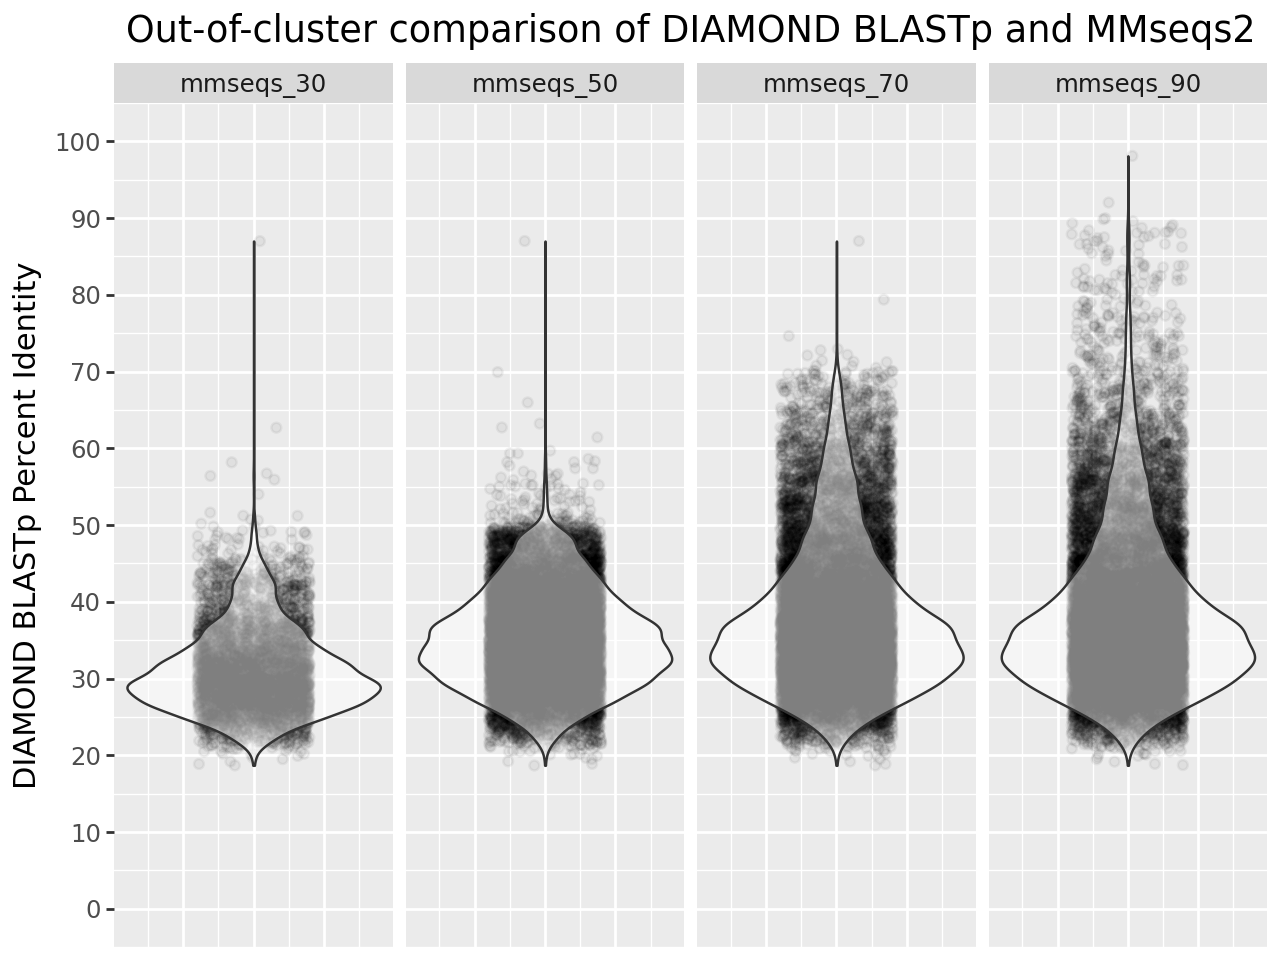

In [14]:
(
    ggplot(results, aes(x=0, y="pident")) +
      geom_point(position = position_jitter( width = 0.2), alpha=0.05) +
      geom_violin( alpha=0.5) +
      coord_cartesian(ylim=(0, 100)) +
      facet_wrap("~z", ncol=4) +
      scale_y_continuous(breaks = range(0, 110, 10)) +
      ylab("DIAMOND BLASTp Percent Identity")  + 
      theme(axis_title_x=element_blank(),
            axis_text_x=element_blank(),
            axis_ticks_x=element_blank(),
            ) +
      ggtitle("Out-of-cluster comparison of DIAMOND BLASTp and MMseqs2") +
        theme(plot_title = element_text(hjust = 0.5))
)

---

In [15]:

sg_obj = SocialGene()
sg_obj.get_proteins_from_neo4j()
_=sg_obj.annotate_proteins_with_neo4j(annotate_all=True)
       

2024-08-07 15:20:05 INFO     Retrieved 16233 proteins from Neo4j                                                                     ]8;id=308617;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/base/socialgene.py\socialgene.py]8;;\:]8;id=101544;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/base/socialgene.py#237\237]8;;\

                    INFO     Searching database for HMM annotations of 16233 proteins.                                               ]8;id=44531;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/base/socialgene.py\socialgene.py]8;;\:]8;id=175750;file:///home/chase/Documents/github/kwan_lab/socialgene/sgpy/socialgene/base/socialgene.py#122\122]8;;\

In [16]:
with GraphDriver() as db:
    df = db.run(
        """
        MATCH z=(p1)-[r:BLASTP]-(p2)
        WITH p1, p2, min(r.pident) as pident
        RETURN p1.uid as a, p2.uid as b, pident
        """
    ).to_df()

In [17]:
df['hmm_compare'] = df.apply(lambda x: mod_score(sg_obj.proteins[x.loc['a']], sg_obj.proteins[x['b']]), axis=1)

In [18]:
df['jaccard'] = df['hmm_compare'].apply(lambda x: x.jaccard)
df['levenshtein'] = df['hmm_compare'].apply(lambda x: x.levenshtein)
df['mod_score'] = df['hmm_compare'].apply(lambda x: x.mod_score)

In [19]:
df

,a,b,pident,hmm_compare,jaccard,levenshtein,mod_score
0,cgnOVQxUid_OEHCdAspR2S9M_oE8ce6S,LMTVd6j-EOqqA3MLNQUAV_bB6ukwgL8c,41.700001,_mod_score_tupler(query=Protein(uid='cgnOVQxUi...,0.97,0.41,0.90
1,LMTVd6j-EOqqA3MLNQUAV_bB6ukwgL8c,cgnOVQxUid_OEHCdAspR2S9M_oE8ce6S,41.700001,_mod_score_tupler(query=Protein(uid='LMTVd6j-E...,0.97,0.41,0.90
2,qCXeBY64WrZRl4TwwycKwzspj13YwcxN,FiURHvGHMO-_Ry2sCe_5AVWFIm0b1ICH,53.299999,_mod_score_tupler(query=Protein(uid='qCXeBY64W...,0.93,0.40,0.87
3,FiURHvGHMO-_Ry2sCe_5AVWFIm0b1ICH,qCXeBY64WrZRl4TwwycKwzspj13YwcxN,53.299999,_mod_score_tupler(query=Protein(uid='FiURHvGHM...,0.93,0.40,0.87
4,MZkeExSXA8_DqY8Ra9sgOH2NCguL4OoL,knlefOq6b9JHoaet0dhsxUNX5FHPF7Iv,37.799999,_mod_score_tupler(query=Protein(uid='MZkeExSXA...,0.80,0.29,0.69
...,...,...,...,...,...,...,...
32575,0nV7ggIfhO5_eBKoA1aG9ArxAlpQnBFl,qIvcgFnu5lSR5IRnG8PDTPsCSgjCKemd,87.000000,_mod_score_tupler(query=Protein(uid='0nV7ggIfh...,1.00,1.00,1.50
32576,qIvcgFnu5lSR5IRnG8PDTPsCSgjCKemd,vfc-p5vlLOP1F_LbSgvkjeLlgi_Gen-V,68.000000,_mod_score_tupler(query=Protein(uid='qIvcgFnu5...,1.00,1.00,1.50
32577,vfc-p5vlLOP1F_LbSgvkjeLlgi_Gen-V,qIvcgFnu5lSR5IRnG8PDTPsCSgjCKemd,68.000000,_mod_score_tupler(query=Protein(uid='vfc-p5vlL...,1.00,1.00,1.50
32578,vfc-p5vlLOP1F_LbSgvkjeLlgi_Gen-V,U_EnMvy7yYMP6c2UmmHkriGOIS1lmF0V,64.300003,_mod_score_tupler(query=Protein(uid='vfc-p5vlL...,1.00,1.00,1.50


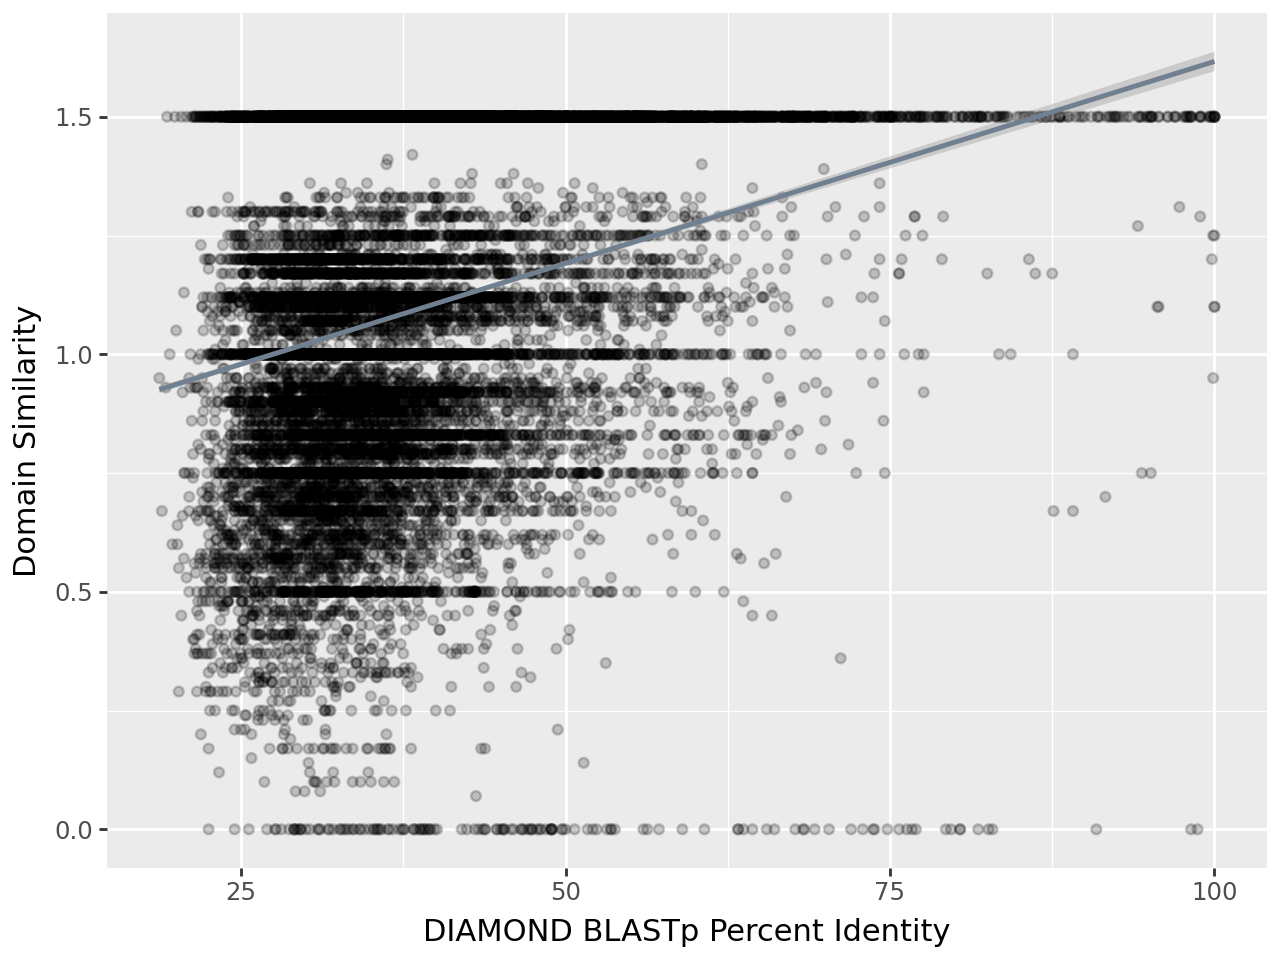

In [20]:
(
    ggplot(df, aes(x="pident", y="mod_score")) +
        geom_point(alpha=0.1) +
        xlab("DIAMOND BLASTp Percent Identity") +
        ylab("Domain Similarity") +
        #add correlation
        geom_smooth(method="lm", color='#708090')
          
)


In [21]:
stats.linregress(df['mod_score'],df['pident'])

LinregressResult(slope=8.577385923925956, intercept=29.03758502910896, rvalue=0.2699521100552676, pvalue=0.0, stderr=0.16950220880253714, intercept_stderr=0.19467130561525015)

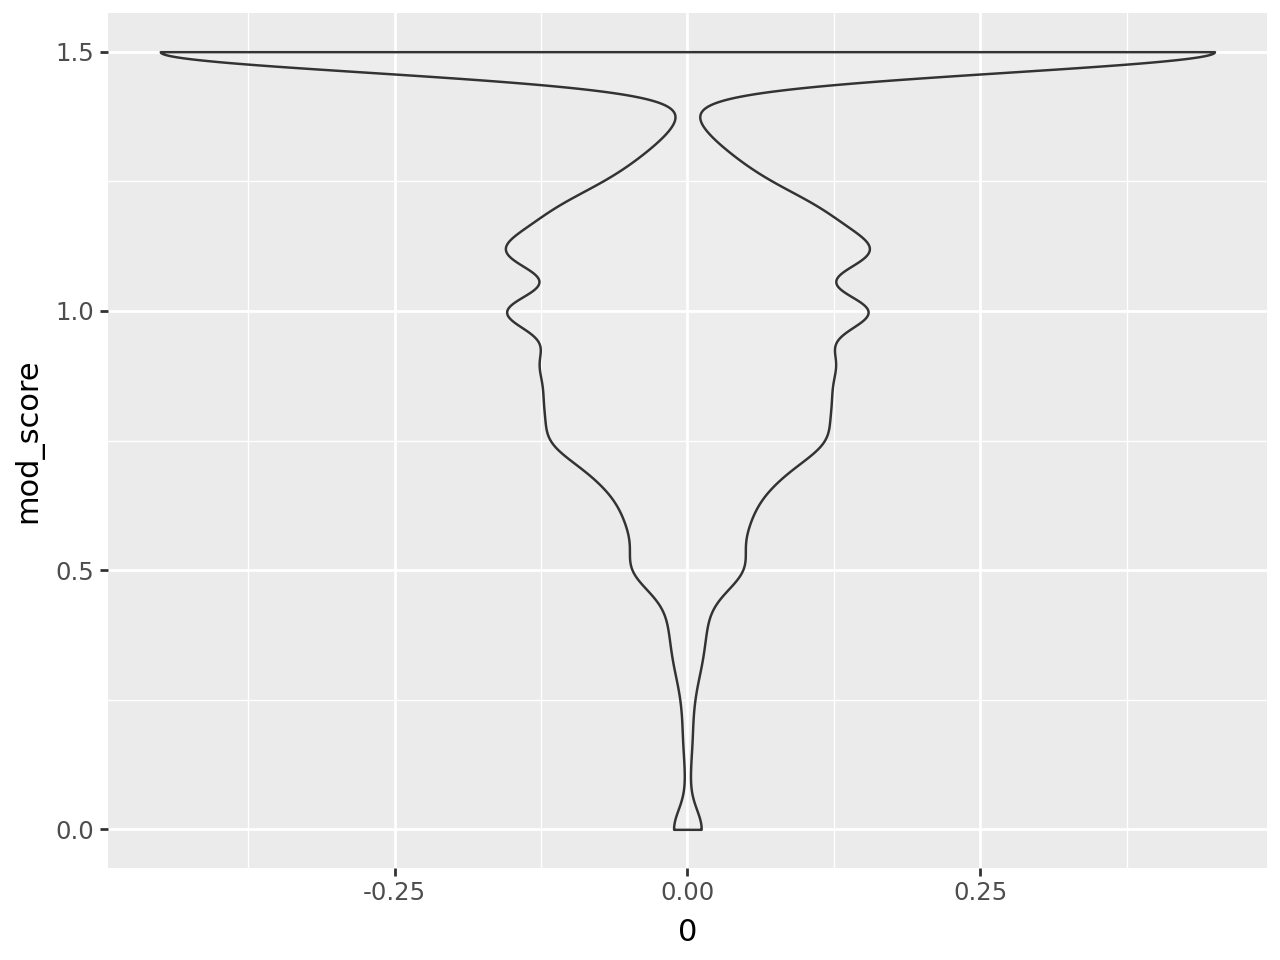

In [22]:
(
    ggplot(df, aes(x=0, y="mod_score")) +
        geom_violin(alpha=0.1)        
          
)

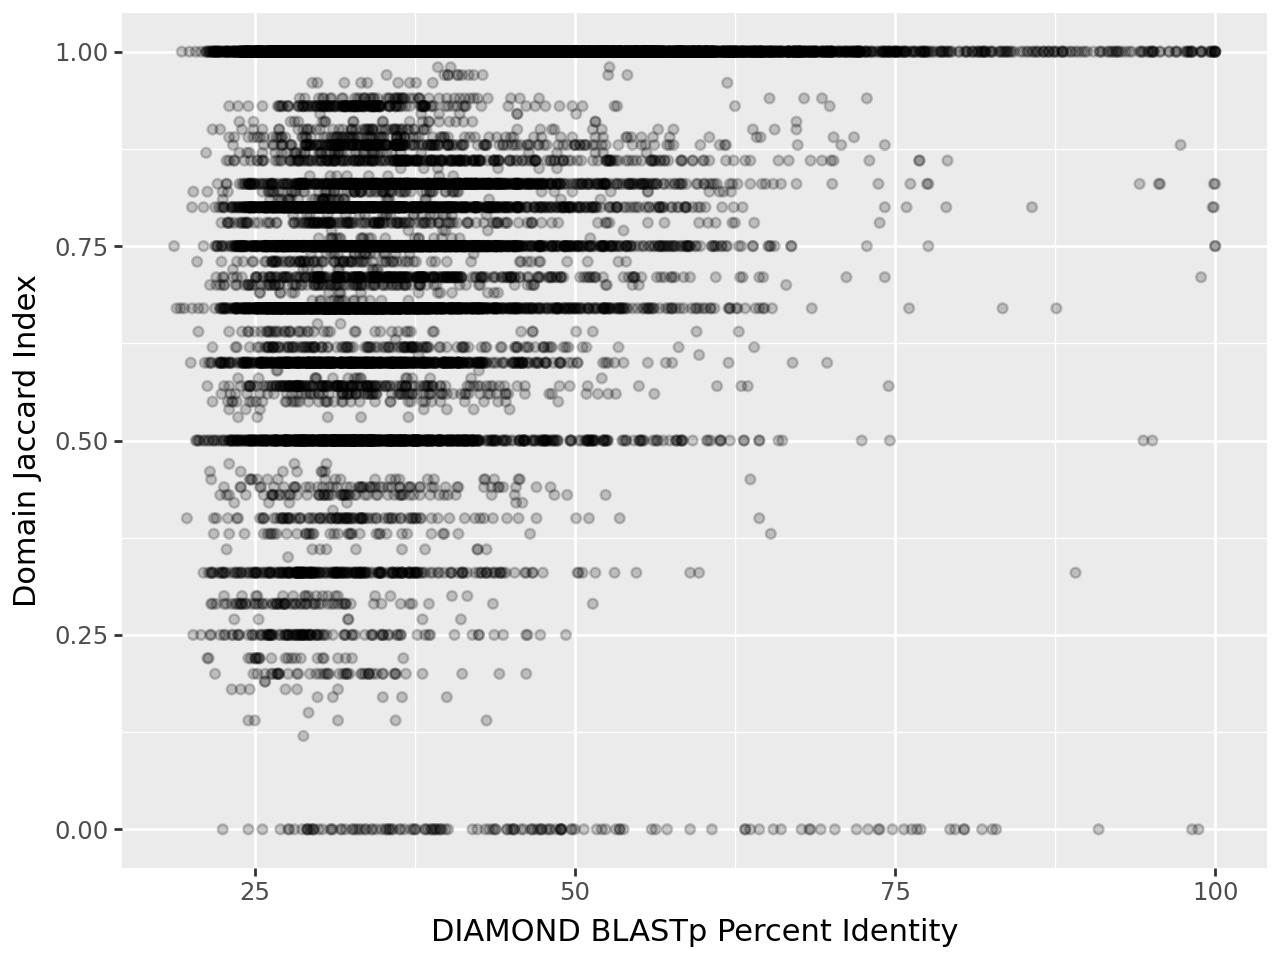

In [23]:
(
    ggplot(df, aes(x="pident", y="jaccard")) +
        geom_point(alpha=0.1) +
        xlab("DIAMOND BLASTp Percent Identity") +
        ylab("Domain Jaccard Index")
          
)

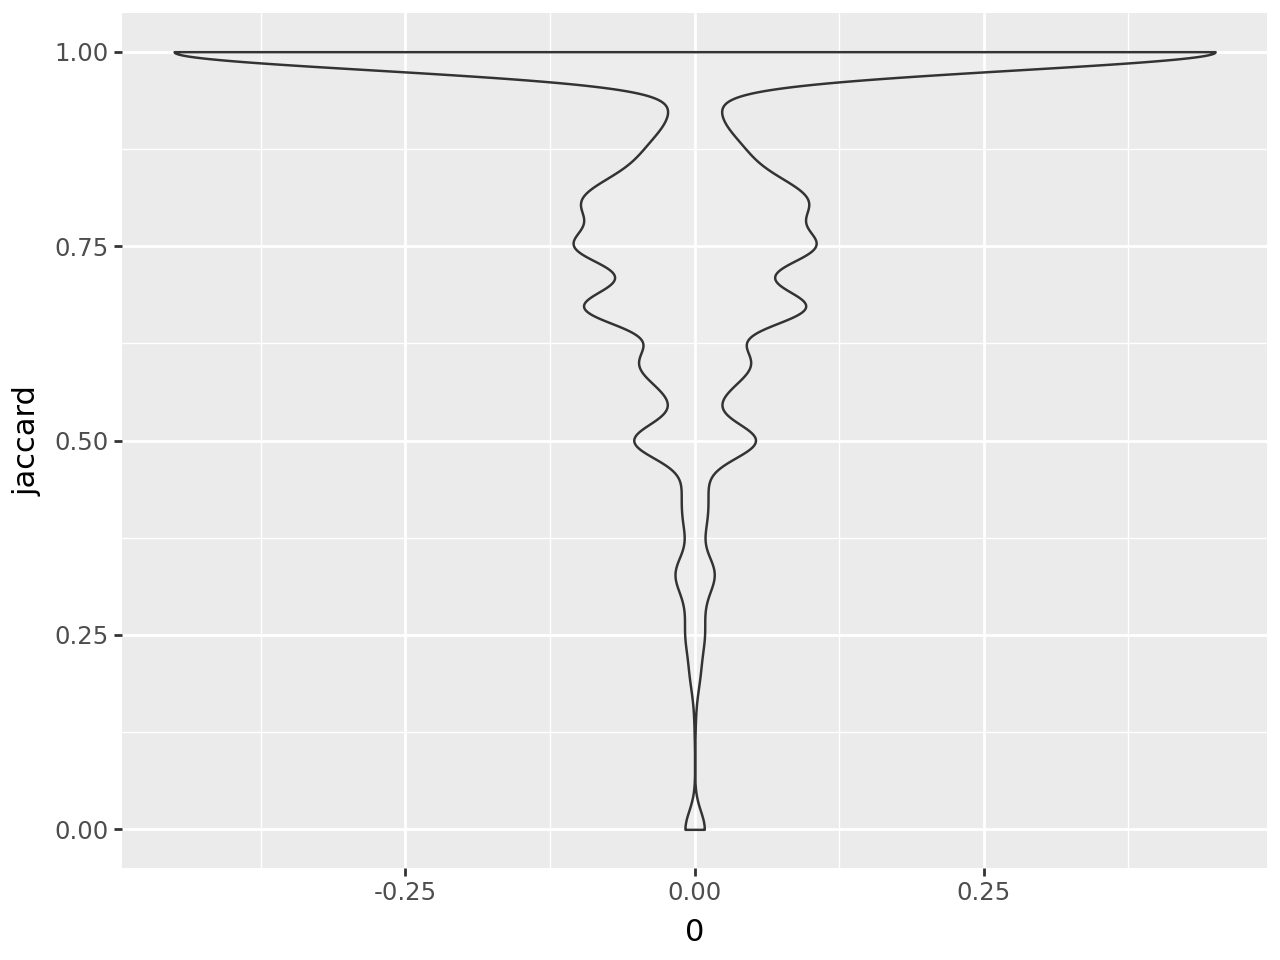

In [24]:
(
    ggplot(df, aes(x=0, y="jaccard")) +
        geom_violin(alpha=0.1) 
        
          
)

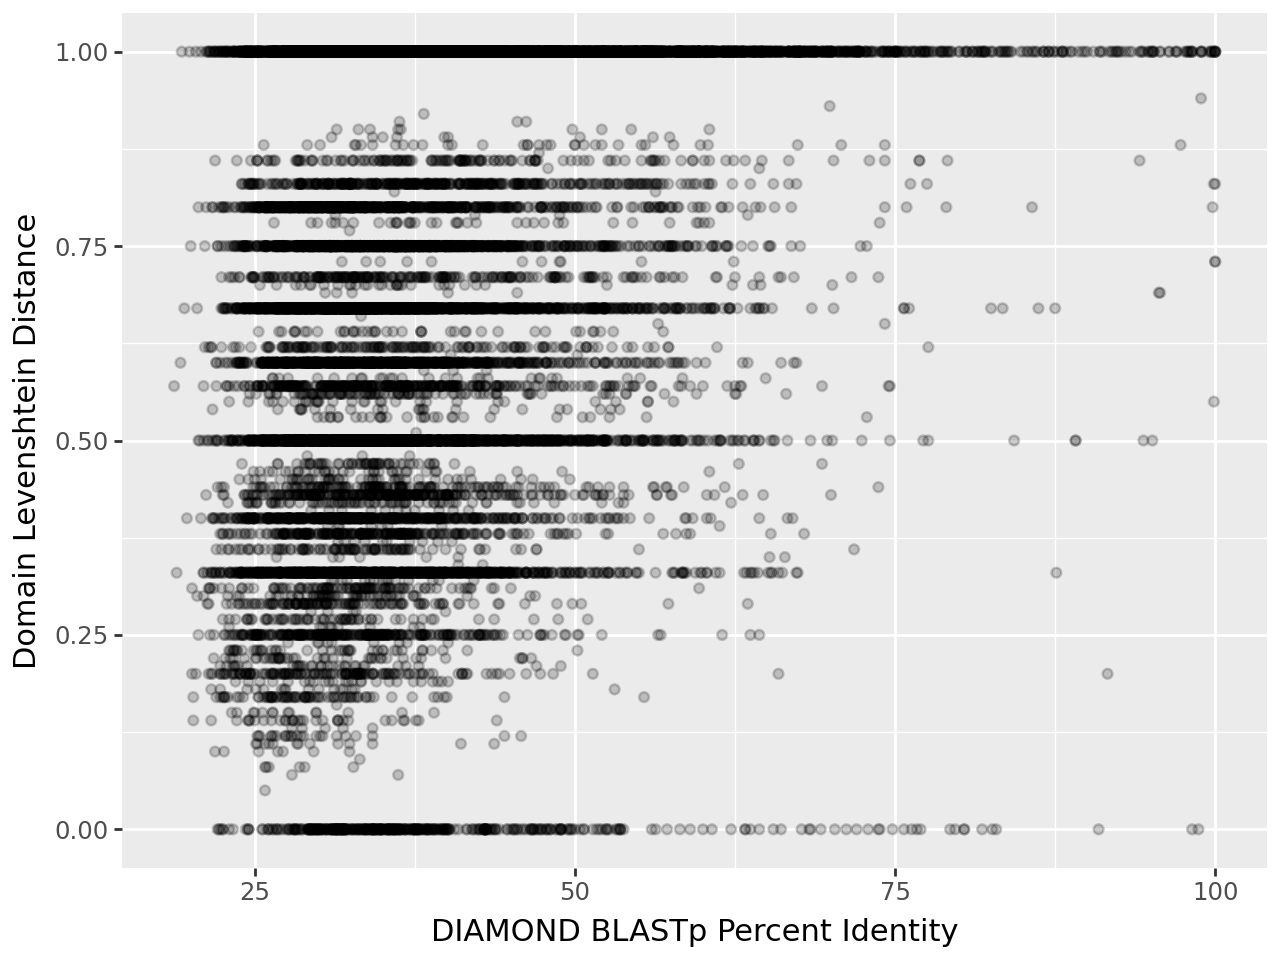

In [25]:
(
    ggplot(df, aes(x="pident", y="levenshtein")) +
        geom_point(alpha=0.1) +
        xlab("DIAMOND BLASTp Percent Identity") +
        ylab("Domain Levenshtein Distance")
          
)

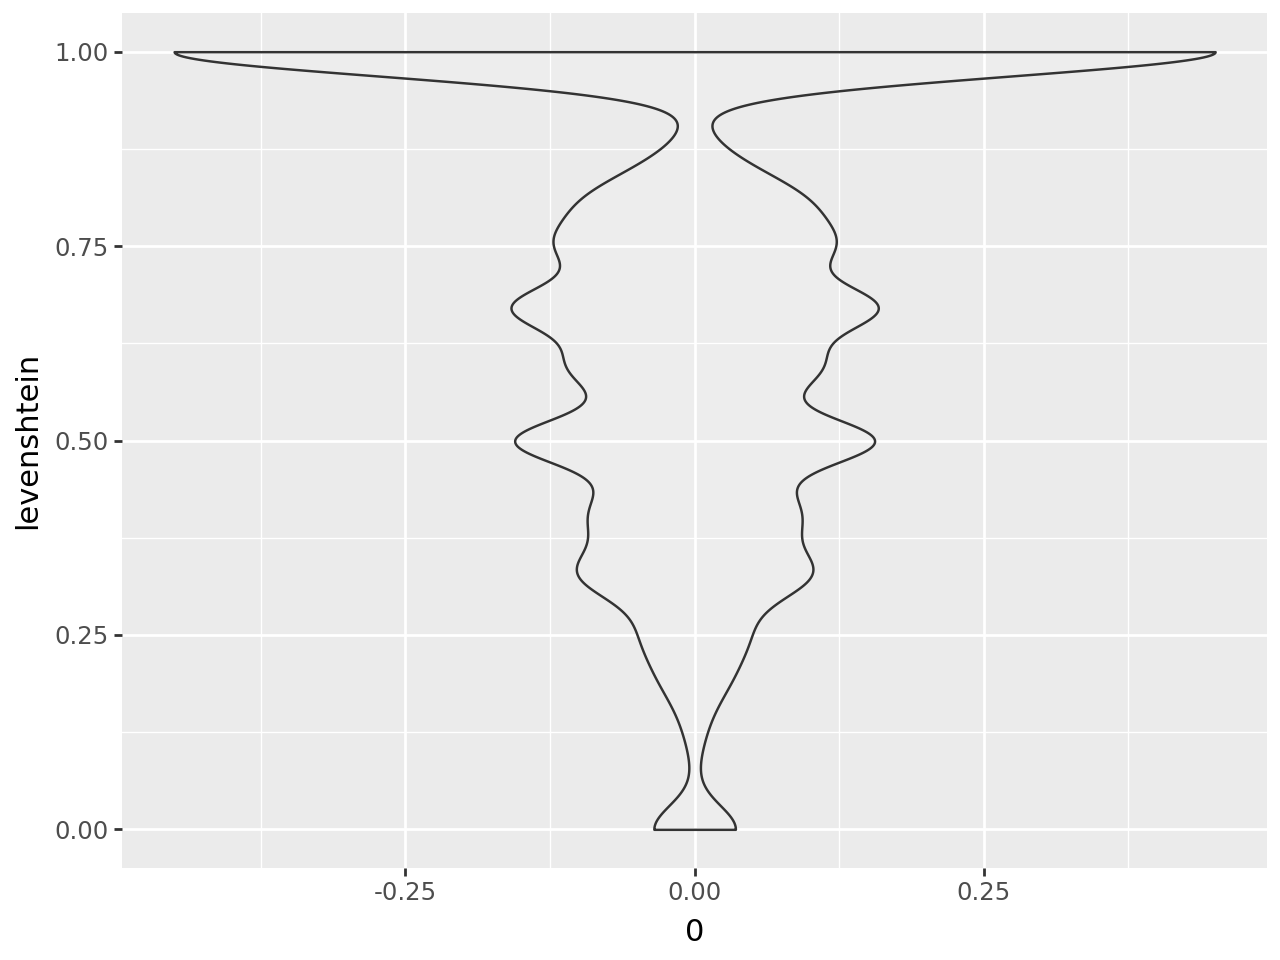

In [26]:
(
    ggplot(df, aes(x=0, y="levenshtein")) +
        geom_violin(alpha=0.1) 
        
          
)